<a href="https://colab.research.google.com/github/owlc33k/jupyter-notebook/blob/master/vgg16_tl_CJL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目的：少ない画像のセットから転移学習を用いて動物の画像の分類を行う。

同階層にあるフォルダ名をラベル、各フォルダ内の画像を学習用データとして用いる

In [0]:
# Google Driveのパスをマウント

from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 呼び出しやすいようにディレクトリまでのPathを設定

import os
base_path = "/content/drive/My Drive/data/CJL/".replace('/', os.sep)

In [0]:
# 必要なライブラリをインポート

import glob
import cv2
import math
import pandas as pd
import numpy as np

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [0]:
# 各フォルダの画像のパスとフォルダ名をリストに読み込む
df = []
for foldername in os.listdir(base_path):
    imgs_path = base_path + foldername
    imgs = sorted(glob.glob(imgs_path + "/" + '*.jpg'))
    
    for name in imgs:
        df.append((str(name), str(foldername)))

# カラム名をつけてデータフレームに格納
df = pd.DataFrame(df, columns=['Image', 'Label'], index=None)

# 初めの5個のデータの確認
df.head()

,Image,Label
0,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
1,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
2,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
3,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah
4,/content/drive/My Drive/data/CJL/Cheetah/00000...,Cheetah


In [0]:
# データ数を表示。モデルを構築するのに用いる全画像の枚数
print(len(df))

257


In [0]:
# データフレームをラベル毎に学習用と検証用に8:2に分割

train_df = pd.DataFrame(columns=['Image', 'Label'], index=None)
val_df = pd.DataFrame(columns=['Image', 'Label'], index=None)
labels = df['Label'].unique()

for label in labels:
  temp_df = df[df['Label'] == label]
  split = math.floor(len(temp_df) * 0.8)
  train_df = pd.concat([train_df, temp_df[0:split]])
  val_df = pd.concat([val_df, temp_df[split:]])

# 学習には各カテゴリにつき60～70枚の画像を用いる
print(train_df.shape)
print(val_df.shape)

(204, 2)
(53, 2)


In [0]:
# データのシャッフル
train_df = train_df.sample(frac=1.,random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1.,random_state=42).reset_index(drop=True)

In [0]:
# 訓練データの読み込みと前処理
img_list = []
imgs = []

# 各画像を読み込んで前処理を加える
for i in range(len(train_df)):
    # 画像の読み込み
    imgs = cv2.imread(train_df['Image'][i],1)
    # 画像のリサイズ（224, 224）
    imgs = cv2.resize(imgs, (224, 224))
    # 画像の正規化
    imgs = imgs.astype('float32') /255
    # リストへ追加
    img_list.append(imgs)
    
# リストからNumpy配列へ変換
X_train = np.array(img_list)

# サイズを確認
X_train.shape

(204, 224, 224, 3)

In [0]:
# 検証用データの読み込みと前処理
img_list = []
imgs = []

# 各画像を読み込んで前処理を加える
for i in range(len(val_df)):
    # 画像の読み込み
    imgs = cv2.imread(val_df['Image'][i],1)
    # 画像のリサイズ（224, 224）
    imgs = cv2.resize(imgs, (224, 224))
    # 画像の正規化
    imgs = imgs.astype('float32') /255
    # リストへ追加
    img_list.append(imgs)
    
# リストからNumpy配列へ変換
X_val = np.array(img_list)

# サイズを確認
X_val.shape

(53, 224, 224, 3)

In [0]:
# 反転等で学習用データを水増し
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.1,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True)

        
# 水増し画像を訓練用画像の形式に合わせる
datagen.fit(X_train)
datagen.fit(X_val)

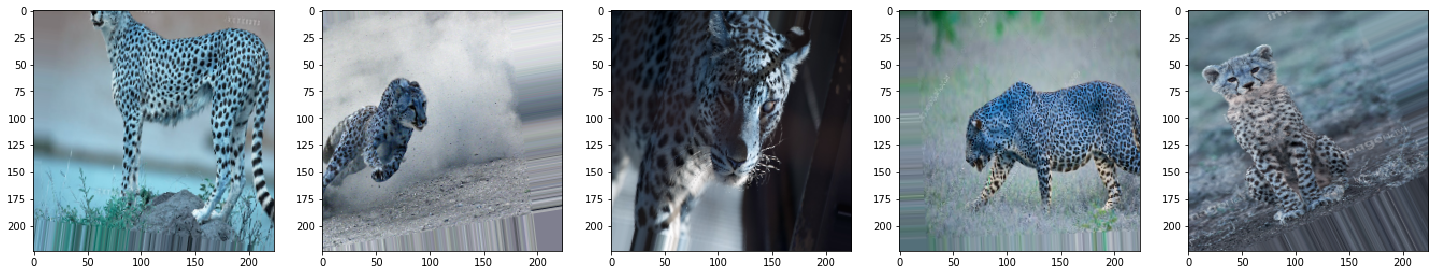

In [0]:
# ImageDataGeneratorによって水増しされた画像を表示。openCVではBGR形式で読み込むため色合いは元画像とは違って表示される
i = 0
aug_img = []
for batch in datagen.flow(X_train, shuffle=False, batch_size=5, seed=42):
    i += 1
    aug_img.append(batch)
    if i > 4:
        break
fig, ax = plt.subplots(1, len(aug_img), figsize=(25,6))
for i in range(len(aug_img)):
  plt.subplot(1, len(aug_img), i + 1)
  plt.imshow(aug_img[0][i])

In [0]:
# ラベルをダミー変数に変換

y_train = pd.get_dummies(train_df['Label']).values
y_val = pd.get_dummies(val_df['Label']).values

In [0]:
# ダミー変数の値はフォルダ名順になっている

print(y_val[0:5])
print(val_df[0:5])

[[0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]]
                                               Image    Label
0  /content/drive/My Drive/data/CJL/Leopard/00009...  Leopard
1  /content/drive/My Drive/data/CJL/Jaguar/000115...   Jaguar
2  /content/drive/My Drive/data/CJL/Jaguar/000122...   Jaguar
3  /content/drive/My Drive/data/CJL/Cheetah/00011...  Cheetah
4  /content/drive/My Drive/data/CJL/Jaguar/000117...   Jaguar


In [0]:
# VGG16のモデルを出力部分を含まない状態で呼び出す
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# モデルの最後が出力層を含まずプーリング層となっている
vgg16.summary()

W0617 01:36:32.161003 140022502664064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 01:36:32.206813 140022502664064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 01:36:32.214810 140022502664064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 01:36:32.260716 140022502664064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0617 01:36:33.727916 140022502664064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 01:36:33.729171 140022502664064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# 呼び出したモデルを使った新しいモデル
model = Sequential(vgg16.layers)

# 第15層までの重みを固定し学習不可にする
for layer in model.layers[:15]:
  layer.trainable = False

# プーリング層からの入力を受け取るため全結合層を追加。出力層のニューロン数は分類数と同じにする。
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# マルチクラス分類のため損失関数はcategorical
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [0]:
# 検証用データの損失関数が20エポックの間下がらない場合学習を停止

early_stopping = EarlyStopping(monitor='val_acc', patience=20 , verbose=1)

In [0]:
# 検証用データの正解率が最も低くなった時のモデルを保存
modelCheckpoint = ModelCheckpoint(filepath = base_path + 'CJL.h5',
                                  monitor='val_acc',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=5)

In [0]:
# モデルの学習

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                              samples_per_epoch=X_train.shape[0],
                              nb_epoch=100,
                              verbose=1,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., verbose=1, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=3, epochs=100)`
  import sys


Epoch 1/100
3/3 [==============================] - 3s 966ms/step - loss: 1.4785 - acc: 0.3906 - val_loss: 1.1501 - val_acc: 0.3208
Epoch 2/100
3/3 [==============================] - 1s 484ms/step - loss: 1.3356 - acc: 0.3863 - val_loss: 1.0759 - val_acc: 0.4151
Epoch 3/100
3/3 [==============================] - 1s 492ms/step - loss: 1.3830 - acc: 0.3411 - val_loss: 1.0324 - val_acc: 0.3774
Epoch 4/100
3/3 [==============================] - 1s 495ms/step - loss: 1.1061 - acc: 0.4602 - val_loss: 0.9273 - val_acc: 0.4906
Epoch 5/100
3/3 [==============================] - 2s 668ms/step - loss: 0.9837 - acc: 0.5312 - val_loss: 0.8804 - val_acc: 0.5283
Epoch 6/100
3/3 [==============================] - 2s 508ms/step - loss: 0.9254 - acc: 0.5231 - val_loss: 0.8442 - val_acc: 0.6038
Epoch 7/100
3/3 [==============================] - 1s 487ms/step - loss: 0.7351 - acc: 0.6591 - val_loss: 0.8228 - val_acc: 0.6226
Epoch 8/100
3/3 [==============================] - 1s 494ms/step - loss: 0.8616 - a

In [0]:
# テストデータの読み込み
test_df = []
imgs = sorted(glob.glob("/content/drive/My Drive/data/CJLtest/" + '*.jpg'))

for name in imgs:
    test_df.append((str(name)))

# データフレームへ格納
test_df = pd.DataFrame(test_df, columns=['Image'], index=None)
test_df.head()

,Image
0,/content/drive/My Drive/data/CJLtest/cheetah1.jpg
1,/content/drive/My Drive/data/CJLtest/jaguar1.jpg
2,/content/drive/My Drive/data/CJLtest/jaguar2.jpg
3,/content/drive/My Drive/data/CJLtest/leopard1.jpg
4,/content/drive/My Drive/data/CJLtest/leopard2.jpg


In [0]:
# テストデータの読み込みと前処理
img_list = []
imgs = []

# 各画像を読み込んで前処理を加える
for i in range(len(test_df)):
    # 画像の読み込み
    imgs = cv2.imread(test_df['Image'][i],1)
    # 画像のリサイズ（224, 224）
    imgs = cv2.resize(imgs, (224, 224))
    # 画像の正規化
    imgs = imgs.astype('float32') /255
    # リストへ追加
    img_list.append(imgs)
    
# リストからNumpy配列へ変換
X_test = np.array(img_list)

# サイズを確認
X_test.shape

(5, 224, 224, 3)

In [0]:
# テスト画像毎に各カテゴリに属する確率を予測
prob = model.predict(X_test)

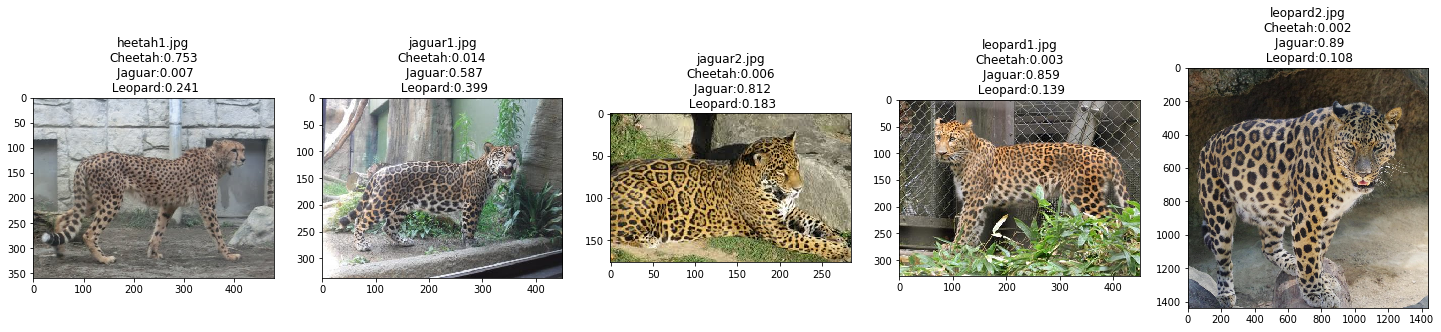

In [0]:
# テスト用画像が入ったフォルダから画像と予測結果を表示。テスト画像では5枚中3枚が正しく分類されている

fig, ax = plt.subplots(1, len(test_df), figsize=(25,6))

plot_number = 1
for i in range(len(test_df)): 
    image = cv2.imread(test_df['Image'].iloc[i],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(1, len(test_df), plot_number)
    img_name = test_df['Image'][i].strip("/content/drive/My Drive/data/CJLtest/")
    title = img_name + "\nCheetah:" + str(round(prob[i][0], 3)) + "\n Jaguar:" + str(round(prob[i][1], 3))  + "\n Leopard:" + str(round(prob[i][2], 3)) 
    plt.imshow(image)
    plt.title(title)
    plot_number = plot_number+1

In [0]:
# 検証データの混同行列を表示すると3番目のクラス（カラム3=Leopard）の分類間違いが多いことがわかる
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
pred_val = model.predict(X_val)
pred = pred_val.argmax(axis=1)
label = y_val.argmax(axis=1)
confusion_matrix(pred, label)

array([[14,  1,  7],
       [ 0, 18,  4],
       [ 4,  0,  5]])

In [0]:
# 混同行列の評価指標
print('正解率：', accuracy_score(pred, label))
print('適合率：', precision_score(pred, label, average = 'macro'))
print('再現率：', recall_score(pred, label, average = 'macro'))
print('Fスコア：', f1_score(pred, label, average = 'macro'))

正解率： 0.6981132075471698
適合率： 0.6792153996101365
再現率： 0.6700336700336701
Fスコア： 0.6593495934959349


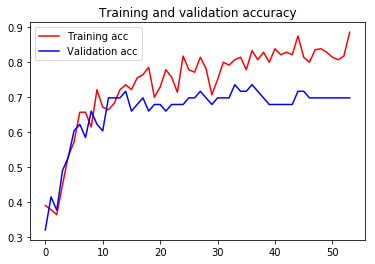

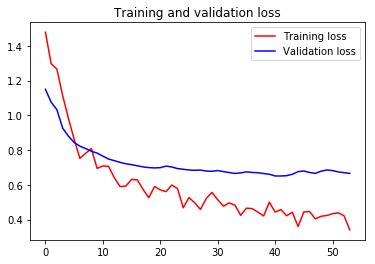

In [0]:
# 高バリアンスのため正解率を上げるには学習用データをもっと集める必要がある

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
